In [72]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field

import operator

from dotenv import load_dotenv
load_dotenv()

True

In [73]:
# model
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature = 0.7)

In [74]:
# structure the output format

class OutputSchema(BaseModel):

      feedback : str = Field(description = "Detailed feedback for the essay")
      score : int = Field(description = "score out of 0 to 10", ge = 0, le = 10)

In [75]:
# model with structured output

model_with_structured_output = model.with_structured_output(OutputSchema)

In [76]:
essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [45]:
# prompt
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'

model_with_structured_output.invoke(prompt).score

9

In [46]:
model_with_structured_output.invoke(prompt).feedback

"The essay is exceptionally well-written, demonstrating a high command of the English language. \n\n**Strengths:**\n1. **Structure and Cohesion:** The essay follows a logical progression, starting with a strong introduction, moving through strengths and applications, addressing challenges, and concluding with a forward-looking summary. Transitions between paragraphs are seamless.\n2. **Vocabulary:** You have used a sophisticated and contextually appropriate range of vocabulary (e.g., 'burgeoning,' 'demographic dividend,' 'interoperability,' 'exacerbate'). This elevates the tone to a professional and academic level.\n3. **Grammar and Syntax:** The sentence structures are varied and complex without becoming convoluted. There are no notable grammatical errors or punctuation mistakes.\n4. **Balanced Perspective:** The essay effectively balances the 'promise' of AI with the 'pressing concerns' like the digital divide and ethics, providing a holistic view of the subject.\n\n**Areas for Impro

In [77]:
# state

class EssayState(TypedDict):

      essay : str

      cot_feedback : str
      doa_feedback : str
      language_feedback : str

      overall_feedback : str

      indevidual_scores : Annotated[list[int], operator.add]  # use or reducer function - to append the scores parally in this list of int

      average_score : float

In [78]:
def cot_feedback_function(state : EssayState) -> EssayState:

      # prompt
      prompt = f'Evaluate the clearity of thaught of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
      
      output = model_with_structured_output.invoke(prompt)

      return {'cot_feedback' : output.feedback, 'indevidual_scores' : [output.score]}

In [79]:
def doa_feedback_function(state : EssayState) -> EssayState:

      # prompt
      prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
      
      output = model_with_structured_output.invoke(prompt)

      return {'doa_feedback' : output.feedback, 'indevidual_scores' : [output.score]}

In [80]:
def language_feedback_function(state : EssayState) -> EssayState:

      # prompt
      prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
      
      output =  model_with_structured_output.invoke(prompt)

      return {'language_feedback' : output.feedback, 'indevidual_scores' : [output.score]}

In [81]:
def evaluation_function(state : EssayState) -> EssayState:

      # summary feedback
      prompt = f"Based on the following feedbacks create a summarized feedback \n language feedback : {state['language_feedback']} \n depth of analysis : {state['doa_feedback']} \n clearity of thaught : {state['cot_feedback']}"
      
      overall_feedback = model.invoke(prompt).content

      # average score
      average_score = sum(state['indevidual_scores']) / len(state['indevidual_scores'])

      return {'overall_feedback' : overall_feedback, 'average_score' : average_score}

In [82]:
# create graph
graph = StateGraph(EssayState)

# add node
graph.add_node("cot_feedback_function", cot_feedback_function)
graph.add_node("doa_feedback_function", doa_feedback_function)
graph.add_node("language_feedback_function", language_feedback_function)

graph.add_node("evaluation_function", evaluation_function)

# add edges
graph.add_edge(START, 'cot_feedback_function')
graph.add_edge(START, 'doa_feedback_function')
graph.add_edge(START, 'language_feedback_function')

graph.add_edge('cot_feedback_function', 'evaluation_function')
graph.add_edge('doa_feedback_function', 'evaluation_function')
graph.add_edge('language_feedback_function', 'evaluation_function')

graph.add_edge('evaluation_function', END)

# compile

workflow = graph.compile()

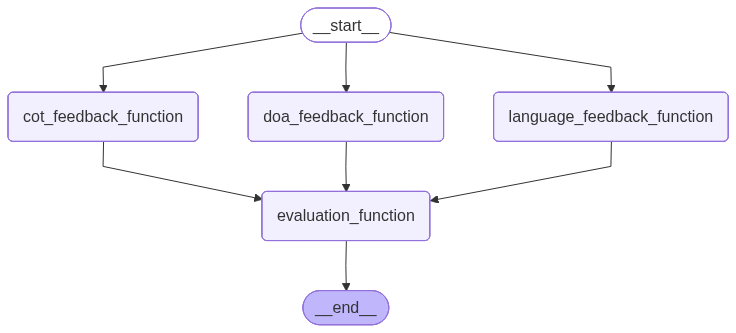

In [83]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [84]:
initial_state = {"essay" : essay}

final_state = workflow.invoke(initial_state)

In [85]:
final_state

{'essay': "India in the Age of AI\nAs the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.\n\nIndia's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for 

In [86]:
final_state['cot_feedback']

"The essay demonstrates excellent clarity of thought. The arguments are logically structured, well-supported with relevant examples, and easy to follow. Each section flows seamlessly into the next, presenting a comprehensive and balanced perspective on India's position in the age of AI. The introduction effectively sets the context, and the conclusion succinctly summarizes the key takeaways, reinforcing the essay's core message. The points on strengths, applications, challenges, and recommendations are all clearly articulated and contribute to a cohesive and insightful analysis."

In [87]:
final_state['doa_feedback']

"The essay provides a comprehensive and well-structured overview of India's position in the age of AI. It effectively highlights both the opportunities (skilled workforce, government initiatives, applications in key sectors) and significant challenges (digital divide, job displacement, data privacy). The analysis is balanced, acknowledging the complexities of AI adoption in a diverse country like India. The essay's strength lies in its clear articulation of the multi-stakeholder approach and the emphasis on human-centered development. \n\nTo enhance the depth of analysis further, the essay could benefit from more specific examples or case studies to illustrate its points. For instance, rather than general mentions, elaborating on a particular successful AI implementation in agriculture or healthcare, or discussing specific government policies beyond 'AI for All,' would add more weight. Additionally, a deeper exploration of the *mechanisms* for overcoming challenges, such as concrete st

In [88]:
final_state['language_feedback']

'The language quality of this essay is exceptional. The vocabulary is rich, precise, and highly appropriate for the subject matter, demonstrating a sophisticated command of English. Sentence structures are varied and complex, contributing to excellent readability and flow. The essay maintains strong coherence and cohesion, with ideas logically connected and presented clearly. There are no grammatical errors or spelling mistakes, and the overall style is academic, professional, and engaging. This is a very well-written piece.'

In [89]:
final_state['indevidual_scores']

[10, 8, 9]

In [90]:
final_state['overall_feedback']

"Here's a summarized feedback based on the provided points:\n\nThe essay demonstrates **exceptional language quality**, characterized by rich, precise vocabulary, sophisticated command of English, and flawless grammar, contributing to excellent readability and flow. **Clarity of thought is outstanding**, with logically structured arguments that are easy to follow, well-supported, and contribute to a cohesive and insightful analysis.\n\nRegarding **depth of analysis**, the essay provides a comprehensive and balanced overview of India's position in AI, effectively highlighting both opportunities and challenges. To further enhance depth, the analysis would benefit from the inclusion of more specific examples or case studies (e.g., successful AI implementations, detailed policy discussions). Additionally, a deeper exploration of the *mechanisms* for overcoming challenges (e.g., concrete strategies for bridging the digital divide, specific regulatory frameworks for data privacy), along with

In [91]:
final_state['average_score']

9.0

In [92]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [93]:
initial_state = {"essay" : essay2}

final_state = workflow.invoke(initial_state)

In [94]:
final_state

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n

In [95]:
final_state['cot_feedback']

'The essay demonstrates a clear understanding of the opportunities and challenges AI presents for India. It effectively covers various sectors like agriculture, health, education, and governance, highlighting both the potential benefits and critical issues such as the digital divide, job displacement, and data privacy. The structure is logical, moving from an introduction to advantages, problems, and a call for inclusive development.\n\nHowever, the clarity of thought is significantly hampered by the very simplistic language, numerous grammatical errors, and informal phrasing throughout the essay. Words like "engine-ear," "doctor place," "big big data," and phrases such as "new tech call Artificial Intel… something" severely detract from the essay\'s professionalism and readability. While the core ideas are present and understandable, their articulation is basic and unrefined. To improve, focus on using more formal vocabulary, correct grammar, and varied sentence structures to convey y

In [96]:
final_state['doa_feedback']

'The essay provides a basic overview of the opportunities and challenges of AI in India, covering areas such as agriculture, health, education, job displacement, and privacy. It demonstrates a rudimentary understanding of the topic by listing several relevant points. However, the depth of analysis is extremely limited. Each point is stated superficially without adequate elaboration, specific examples, or detailed reasoning. The language used is overly simplistic, informal, and contains grammatical errors, which significantly detracts from its academic quality and persuasive power. To improve, the essay needs more sophisticated vocabulary, clearer sentence structure, and a much deeper exploration of each argument, moving beyond mere listing to actual analysis and critical thinking.'

In [97]:
final_state['language_feedback']

"The essay addresses the topic of AI in India, touching upon its potential, challenges, and recommendations. However, the language quality significantly detracts from its effectiveness. There are numerous grammatical errors, including issues with subject-verb agreement (e.g., 'world change', 'India have'), tense consistency, and article usage. The vocabulary is very limited and repetitive (e.g., 'big', 'good', 'bad'). Sentence structures are overly simplistic and often clunky. Phrases like 'engine-ear' and 'Intel… something' indicate a lack of precision. To improve, focus on expanding vocabulary, practicing correct grammar, varying sentence structures, and maintaining a more formal tone suitable for an essay."

In [98]:
final_state['indevidual_scores']

[6, 3, 3]

In [99]:
final_state['overall_feedback']

'Here\'s a summarized feedback based on the provided points:\n\nOverall, your essay demonstrates a **foundational understanding** of the opportunities and challenges of AI in India, covering relevant sectors like agriculture, health, and education, and presenting a logical structure from introduction to recommendations. Your core ideas regarding AI\'s potential benefits and critical issues like job displacement and data privacy are present and understandable.\n\nHowever, the **effectiveness and academic quality of your essay are severely hampered** by significant weaknesses in two key areas:\n\n1.  **Language and Expression:** This is the most pervasive issue. The essay is riddled with **numerous grammatical errors** (e.g., subject-verb agreement, tense consistency, article usage), a **very limited and repetitive vocabulary**, and **overly simplistic, clunky sentence structures**. The tone is consistently **informal**, with imprecise phrasing (e.g., "engine-ear," "Intel… something," "d

In [100]:
final_state['average_score']

4.0